# Model 1: Sentiment Analysis
### Importing Libraries

In [ ]:
""" A Sentiment analysis pipeline using DistilRoBERTa model"""
# Import necessary libraries
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import pipeline, AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, EarlyStoppingCallback, get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
import textwrap
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch

# Loading the dataset and initializing

In [3]:
final_df = pd.read_csv('final_dataset.csv')

# Combine title and text columns into a single review column to provide more context
final_df['review'] = final_df['title'].fillna('') + '. ' + final_df['text'].fillna('')

# tqdm initialization for pandas
tqdm.pandas()

# Constants
TRAIN_MODEL = False
SAVE_MODEL = False

MODEL_NAME = "distilbert/distilroberta-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Analyzing then length of the reviews

Token indices sequence length is longer than the specified maximum sequence length for this model (811 > 512). Running this sequence through the model will result in indexing errors


Minimum review length: 38
Median review length: 94
Mean review length: 129
Maximum review length: 7409


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


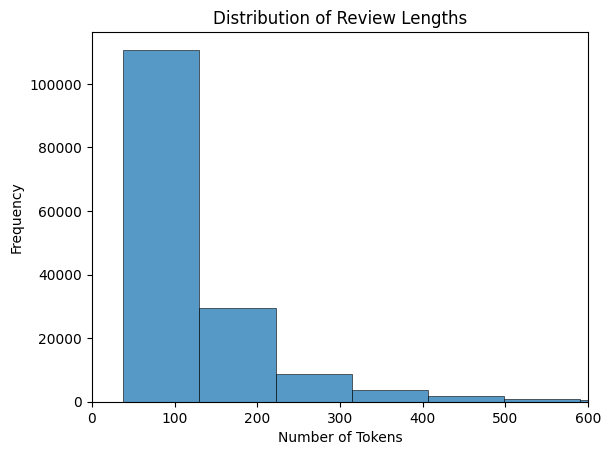

In [5]:
# Analyze the distribution of review lengths
final_df['review_length'] = final_df['review'].apply(lambda x: len(tokenizer.tokenize(x)))

# Print summary statistics
print(f"Minimum review length: {final_df['review_length'].min()}")
print(f"Median review length: {int(final_df['review_length'].median())}")
print(f"Mean review length: {int(final_df['review_length'].mean())}")
print(f"Maximum review length: {final_df['review_length'].max()}")

# Plotting the distribution of review lengths
sns.histplot(final_df['review_length'], bins=80)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.xlim(0, 600)
plt.show()

In [6]:
# Implement sliding window tokenization for reviews longer than 512 tokens
def sliding_window_tokenizer(text, max_length=400, stride=100):
    return tokenizer(text, truncation=True, max_length=max_length, stride=stride, return_overflowing_tokens=True)

# Apply sliding window tokenization to reviews
sliding_tokenized_reviews = []
for review in tqdm(final_df['review'], desc="Tokenizing Reviews"):
    tokenized_chunks = sliding_window_tokenizer(review)
    sliding_tokenized_reviews.extend(tokenized_chunks['input_ids'])

Tokenizing Reviews: 100%|██████████| 157109/157109 [00:57<00:00, 2719.09it/s]


# Generating the labels for Sentiment

In [9]:
# Initialize tokenizer with max length for consistency
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, model_max_length=512)

# Load the DistilRoBERTa model for sentiment analysis
classifier = pipeline("sentiment-analysis", model='./sentiment-fine-tuned-distilroberta', tokenizer=tokenizer, device=0)

# Apply DistilRoBERTa sentiment analysis on the 'review' column with progress tracking
def transformer_sentiment(text):
    # Use consistent max_length and padding to prevent size mismatches
    result = classifier(text, truncation=True, padding=True, max_length=512)[0]
    return result['label'], result['score']

# Apply the new sentiment function with progress tracking
final_df[['sentiment', 'sentiment_score']] = final_df['review'].progress_apply(lambda x: pd.Series(transformer_sentiment(x)))

  0%|          | 2/157109 [00:01<27:06:32,  1.61it/s]/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 157109/157109 [11:37<00:00, 225.35it/s]


### Visualization of label distribution and ratings

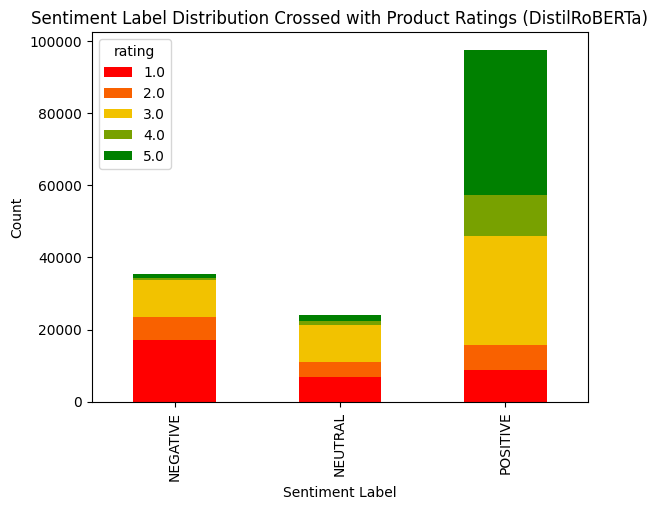

In [10]:
from matplotlib.colors import LinearSegmentedColormap

# Cross-tabulate sentiment with product ratings to visualize the alignment
cross_tab = pd.crosstab(final_df['sentiment'], final_df['rating'])
custom_cmap = LinearSegmentedColormap.from_list('red_to_green', ['red', '#f3c200', 'green'])
cross_tab.plot(kind='bar', stacked=True, colormap=custom_cmap)
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment Label Distribution Crossed with Product Ratings (DistilRoBERTa)')
plt.show()

### Saving Dataframe with the labels

In [11]:
# Reorder columns and drop null rows
final_df = final_df[['title', 'text', 'review', 'rating', 'sentiment', 'sentiment_score', 'id', 'name', 'categories', 'review_length']]
final_df.dropna(inplace=True, axis=0) # Double check for null values

# Save the processed dataset
final_df.to_pickle('final_dataset_sent.pkl')

#final_df = pd.read_pickle('final_dataset_sent.pkl')

# Model configuration before training
### Train, Test, Val Split

In [13]:
# Map sentiment to labels
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
final_df['labels'] = final_df['sentiment'].map(label_mapping)

# Convert to Dataset
dataset = Dataset.from_pandas(final_df[['review', 'labels']])

# Split into train, validation, and test sets with stratification
df = final_df[['review', 'labels']]
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['labels'], random_state=42)

# Convert splits to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

### Tokenization

In [14]:
# Preprocess function
def preprocess_function(examples):
    return tokenizer(examples["review"], truncation=True, max_length=256)

# Tokenize datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True).remove_columns(['review'])
tokenized_val = val_dataset.map(preprocess_function, batched=True).remove_columns(['review'])
tokenized_test = test_dataset.map(preprocess_function, batched=True).remove_columns(['review'])


# Define a dict mapping label IDs to their corresponding label names and viceversa
id2label = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
label2id = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}

# Model setup
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id)

# Using dynamic padding since our sequences have variable lengths and it's more memory efficient
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

Map:   0%|          | 0/94265 [00:00<?, ? examples/s]

Map:   0%|          | 0/31422 [00:00<?, ? examples/s]

Map:   0%|          | 0/31422 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Methods for Training adjustments

In [15]:
# Load the necessary metrics
#metrics = evaluate.load("accuracy","f1_score","precision","recall")
metrics = evaluate.load("accuracy")

# Compute metrics
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metrics.compute(predictions=predictions, references=labels)

# Calculate class weights using sklearn's compute_class_weight
claslabels = [0, 1, 2]  #  classes for NEGATIVE, NEUTRAL, POSITIVE
weights = compute_class_weight(class_weight='balanced', classes=claslabels, y=final_df['labels'].values)
weights_tensor = torch.tensor(weights, dtype=torch.float32, device='cuda')  # Changed dtype to float32

# Custom Trainer class to override the loss computation
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        global weights_tensor
        labels = inputs.get("labels")
        
        outputs = model(**inputs)
        loss = torch.nn.functional.cross_entropy(outputs.logits, labels, weight=weights_tensor)
        return (loss, outputs) if return_outputs else loss

# Training
### Training Arguments and hyperparameters using Trainer API

In [16]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    gradient_accumulation_steps=2,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy='steps',
    logging_steps=100,
    report_to=['none'],
    logging_first_step=True,
    dataloader_num_workers=8,
    fp16=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    disable_tqdm=False,
)

# Initialize learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=training_args.num_train_epochs * len(tokenized_train)
)

trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    optimizers=(optimizer, lr_scheduler)
)

if TRAIN_MODEL:
    trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenize

Epoch,Training Loss,Validation Loss,Accuracy
0,0.514500,0.376580,0.852015
2,0.243000,0.228415,0.924766
4,0.181600,0.205759,0.930876
6,0.132400,0.248490,0.924830


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenize

TrainOutput(global_step=2579, training_loss=0.265753840790002, metrics={'train_runtime': 1446.796, 'train_samples_per_second': 1303.086, 'train_steps_per_second': 5.087, 'total_flos': 4.370541708024576e+16, 'train_loss': 0.265753840790002, 'epoch': 7.0})

### Saving the model

In [18]:
if SAVE_MODEL:
    trainer.save_model('./sentiment-fine-tuned-distilroberta')

In [19]:
local_model = AutoModelForSequenceClassification.from_pretrained('./sentiment-fine-tuned-distilroberta')

# Evaulation and Inference

In [ ]:
with open("eval_results.txt", "w") as f:
    print(trainer.evaluate())

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenize

              precision    recall  f1-score   support

    NEGATIVE       0.90      0.92      0.91      7079
     NEUTRAL       0.79      0.88      0.83      4818
    POSITIVE       0.98      0.94      0.96     19525

    accuracy                           0.93     31422
   macro avg       0.89      0.91      0.90     31422
weighted avg       0.93      0.93      0.93     31422



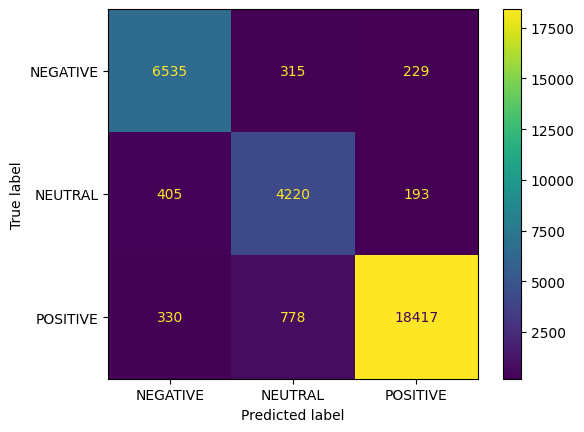

In [20]:
# Load classifier for predictions
classifier = pipeline("sentiment-analysis", model="./sentiment-fine-tuned-distilroberta")

# Evaluate the model on the test set and calculate additional metrics
predictions, labels, metrics = trainer.predict(tokenized_test)
logits = predictions  # The predictions variable contains the logits
predicted_labels = np.argmax(logits, axis=-1)

# Calculate classification report
print(classification_report(labels, predicted_labels, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))

# Confusion matrix
cm = confusion_matrix(labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
disp.plot(cmap='viridis')
plt.show()

with open('Sentiment_Predictions.txt', 'w') as f:
    # Print and classify a few sampled texts
    sampled_texts = test_dataset.shuffle().select(range(5))['review']
    for text in sampled_texts:
        print(textwrap.fill(f"TEXT: {text}", width=80), file=f)
        print(f"CLASSIFICATION: {classifier(text)}\n", file=f)
        print('-'*80, file=f)